# Capacity Expansion Tutorial

In this tutorial, we will use `osier` to optimize the capacity for a test energy system using 
`osier`'s `CapacityExpansion` model. 

1. First we will size a natural gas plant and battery storage for a test system while minimizing total cost.

2. Next, we will replace the natural gas plant with a wind turbine while still only minimizing for total cost.

3. Lastly, we reintroduce the natural gas plant and co-optimize two objectives, total cost and lifecycle carbon emissions.


**Important Caveat**

For simplicity and the sake of time, this notebook specifies a certain number of generations before the model terminates. Therefore it is unlikely that the capacity expansion models shown in this notebook are fully converged. These results should be used for instructional purposes only!

In [1]:
# basic imports
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hour, day, MW
import sys

# osier imports
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize


# set the solver based on operating system -- assumes glpk or cbc is installed.
if "win32" in sys.platform:
    solver = 'cplex'
elif "linux" in sys.platform:
    solver = "cbc"
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cbc


As before, `osier` needs two fundamental things in order to run the model

1. A technology set
2. A net demand profile

Let's create both of these, first. This time, we'll also create a dummy "wind" profile and a wind technology to use in the latter two examples.
We'll also borrow some code from the dispatch tutorial.

## Creating the demand profile

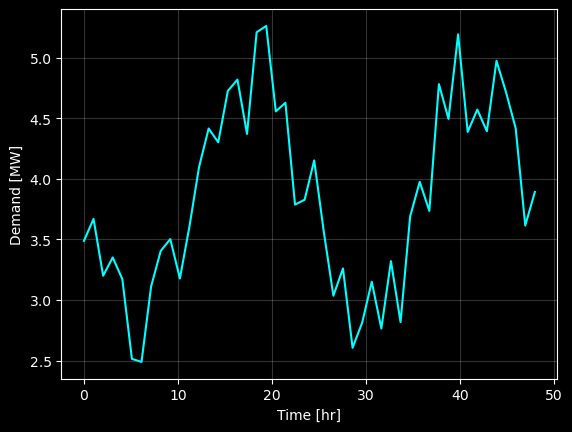

In [2]:
n_hours = 24  # hours per day
n_days = 2  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 185  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.grid(alpha=0.2)
    plt.show()

## Creating the "wind" profile

Wind speeds follow a Weibull distribution 

$f(v) = \left(\frac{k}{\lambda}\right)\left(\frac{v}{\lambda}\right)^{k-1}e^{-\left(\frac{v}{\lambda}\right)^k}$

Where $v$ is our random variable (velocity).

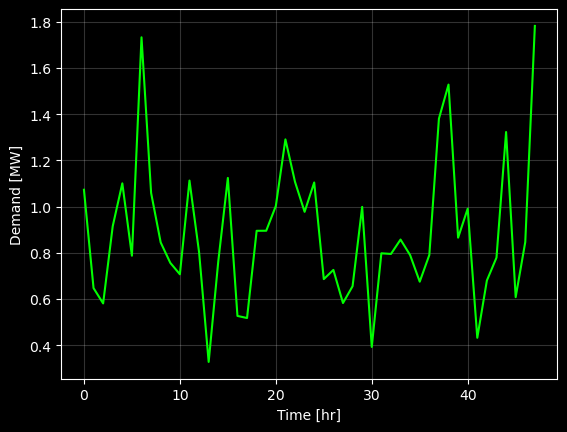

In [3]:
np.random.seed(123)
shape_factor = 2.5
wind_speed = np.random.weibull(a=shape_factor,size=N)

with plt.style.context('dark_background'):
    plt.plot(wind_speed, color='lime')
    plt.grid(alpha=0.2)
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.show()
    

`osier.CapacityExpansion` will normalize the wind and solar profiles and rescale the maximum values to the rated capacity of the installed technology (for each "individual" portfolio tested). Just for fun, let's plot the "net demand" if this wind speed were the true value.

Also note that the weibull distribution is related to wind *speed*, not energy production. For simplicity, we will assume they're equal.

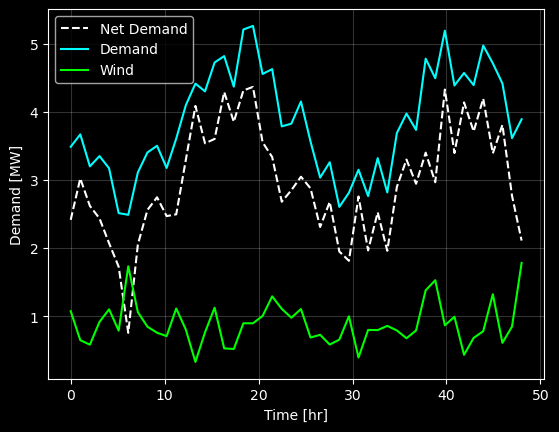

In [4]:
with plt.style.context('dark_background'):
    plt.plot(hours, demand-wind_speed, color='white', linestyle='--', label='Net Demand')
    plt.plot(hours, demand, color='cyan', label='Demand')
    plt.plot(hours, wind_speed, color='lime', label='Wind')
    plt.grid(alpha=0.2)
    plt.ylabel('Demand [MW]')
    plt.xlabel('Time [hr]')
    plt.legend()
    plt.show()

## Creating the Technology Mix

Let's try to meet demand with a properly sized wind turbine and storage combination.

In [5]:
technologies = [lib.battery, lib.wind]
technologies

[Battery: 815.3412599999999 MW, WindTurbine: 0.0 MW]

## Setting up the Capacity Expansion Problem

`osier.CapacityExpansion` inherits from a `pymoo.Problem` object. This class does not run the optimization itself, so we'll have to add the `pymoo` pieces later. Before we can instantiate the problem, though, we need to define the **objectives** to optimize over!

### Defining objectives

`osier` comes with a set of predefined objectives, such as cost and carbon emissions. Let's start with cost.

In [6]:
from osier import total_cost

In [7]:
problem = CapacityExpansion(technology_list = [lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            objectives = [total_cost],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

### Setting up a Pymoo algorithm

Pymoo might seem intimidating, but it too requires only a few fundamental pieces

1. An algorithm object (imported from Pymoo)
2. A problem to optimize (we created this in the previous cell!)
3. A stopping criterion.

The rest is extra.

In [8]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      1 |             - |             -
     2 |       40 |      1 |  0.0515267085 |         ideal
     3 |       60 |      1 |  0.000000E+00 |             f
     4 |       80 |      1 |  0.0086827427 |         ideal
     5 |      100 |      1 |  0.0247637865 |         ideal
     6 |      120 |      1 |  0.0133694299 |         ideal
     7 |      140 |      1 |  0.0041190723 |         ideal
     8 |      160 |      1 |  0.0019521205 |             f
     9 |      180 |      1 |  0.0019521205 |             f
    10 |      200 |      1 |  0.0019521205 |             f
The simulation took 3.694 minutes.


## Checking the results

We can check the results by printing the results from the `res` object. The `res` object has two variables: `res.F`, which contains the objective function results, and `res.X` which contains the corresponding energy system portfolios.

Seeing how the dispatch model uses each of the specified technologies can be useful for debugging purposes.

In [9]:
display(res.F, res.X)

array([0.26153658])

array([0.77856667, 0.24877284])

In [10]:
from osier import DispatchModel
lib.battery.capacity =  res.X[1]*demand.max()*MW
lib.natural_gas.capacity = res.X[0]*demand.max()*MW

technologies = [lib.natural_gas, lib.battery]
display(technologies)

model = DispatchModel(technology_list=technologies,
                      net_demand=demand)
model.solve(solver=solver)

[NaturalGas_Conv: 4.097274671524196 MW, Battery: 1.3091886448082077 MW]

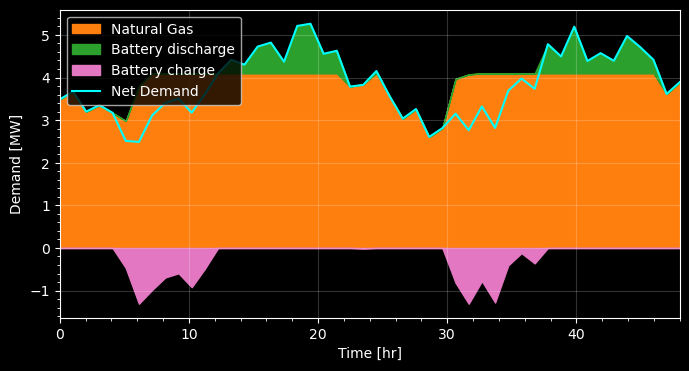

In [11]:
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.grid(alpha=0.2)
    ax.minorticks_on()
    ax.fill_between(hours, 
                    y1=0, 
                    y2=model.results['NaturalGas_Conv'].values, 
                    color='tab:orange', 
                    label='Natural Gas')
    ax.fill_between(hours, 
                    y1=model.results['NaturalGas_Conv'].values, 
                    y2=model.results['Battery'].values+model.results['NaturalGas_Conv'].values, 
                    color='tab:green', 
                    label='Battery discharge')
    ax.fill_between(hours, 
                    y1=0, 
                    y2=model.results['Battery_charge'].values, 
                    color='tab:pink', 
                    label='Battery charge')
    ax.plot(hours, model.net_demand, color='cyan', label='Net Demand')
    ax.set_xlim(0,48)
    # ax.set_ylim(0,5.5)
    ax.legend(loc='upper left')
    ax.set_ylabel("Demand [MW]")
    ax.set_xlabel("Time [hr]")
    plt.show()

## Adding renewable energy to a model


The previous model used natural gas and batteries to meet demand. What if we wanted to include wind as well?

#### How the Capacity Expansion model tests points

By default, the capacity expansion model samples a set of values, $\mathcal{X}_i$, between 0 and 1 (inclusive), for each
technology in the technology list where $\mathcal{X}$ represents a fraction of the maximum energy demand (up to 100%). The capacity of 
each technology is calculated by 

$\mathcal{C}_i = \mathcal{X}_i\cdot \max\left(\mathcal{E}\right)$

where $\mathcal{E}$ is the energy demand time series.

Therefore, the maximum possible capacity for any technology is equal to the maximum demand energy demand. This is fine for dispatchable technologies because we can always choose to turn a dispatchable technology on or off. This is not true for variable renewable energy sources,
such as wind. If we only built enough wind turbine capacity to match the peak demand value we

1. cannot be sure that the peak production will align with peak demand and
2. it is extremely unlikely that peak production will be sustained for any amount of time.

To get around this, we can specify a peak value greater than one. This value can be as high as you want -- but best results are usually found when the maximum capacity for a renewable source is 

$\max\left(\mathcal{X}\right) = \frac{1}{CF}$,

where $CF$ is the average capacity factor.

In [12]:
problem = CapacityExpansion(technology_list = [lib.wind, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [13]:

algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      1 |             - |             -
     2 |       40 |      1 |  0.000000E+00 |             f
     3 |       60 |      1 |  0.0731198079 |         ideal
     4 |       80 |      1 |  0.000000E+00 |             f
     5 |      100 |      1 |  0.0023483206 |             f
     6 |      120 |      1 |  0.0255449274 |         ideal
     7 |      140 |      1 |  0.000000E+00 |             f
     8 |      160 |      1 |  0.000000E+00 |             f
     9 |      180 |      1 |  0.000000E+00 |             f
    10 |      200 |      1 |  0.0002146070 |             f
The simulation took 2.385 minutes.


In [14]:
technologies = []
for X,tech in zip(res.X,problem.technology_list):
    tech.capacity = X*problem.max_demand
    technologies.append(tech)
display(technologies)
# normalize the wind speed
wind_speed = (wind_speed / wind_speed.max()) * res.X[0]*problem.max_demand
net_dem = demand*MW - wind_speed
display(f"Max wind production: {wind_speed.max()}")

model = DispatchModel(technology_list=[technologies[1]],
                      net_demand=net_dem)
model.solve(solver=solver)

[WindTurbine: 10.135967781702929 MW, Battery: 2.7950442069865686 MW]

'Max wind production: 10.135967781702929 MW'

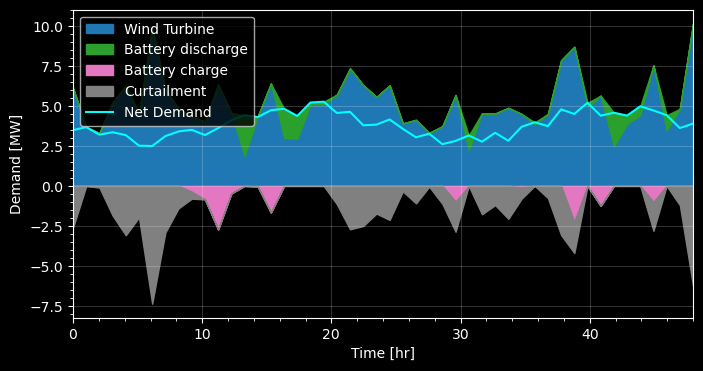

In [15]:
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.grid(alpha=0.2)
    ax.minorticks_on()
    ax.fill_between(hours, 
                    y1=0, 
                    y2=np.array(wind_speed), 
                    color='tab:blue', 
                    label='Wind Turbine')
    ax.fill_between(hours, 
                    y1=np.array(wind_speed), 
                    y2=model.results['Battery'].values+np.array(wind_speed), 
                    color='tab:green', 
                    label='Battery discharge')
    ax.fill_between(hours, 
                    y1=0, 
                    y2=model.results['Battery_charge'].values, 
                    color='tab:pink', 
                    label='Battery charge')
    ax.fill_between(hours, 
                    y1=model.results['Battery_charge'].values, 
                    y2=model.results['Battery_charge'].values+model.results['Curtailment'].values, 
                    color='gray', 
                    label='Curtailment')
    ax.plot(hours, demand, color='cyan', label='Net Demand')
    ax.set_xlim(0,48)
    # ax.set_ylim(0,5.5)
    ax.legend(loc='upper left')
    ax.set_ylabel("Demand [MW]")
    ax.set_xlabel("Time [hr]")
    plt.show()

## Multiple Objectives

What if we want to examine multiple objectives?

We simply have to import the objective we want and add it to the list! Let's checkout lifecycle CO $_2$ emissions.

In [16]:
from osier import annual_emission

# the default emission is `lifecycle_co2_rate`

In [17]:
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [18]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      6 |             - |             -
     2 |       40 |      4 |  0.0158631600 |         nadir
     3 |       60 |      6 |  0.0046803095 |         nadir
     4 |       80 |     13 |  0.0075483249 |         ideal
     5 |      100 |     11 |  0.0286189132 |         ideal
     6 |      120 |     16 |  0.0143108619 |             f
     7 |      140 |     19 |  0.0038096293 |         ideal
     8 |      160 |     20 |  0.0123935101 |             f
     9 |      180 |     20 |  0.0488020532 |         nadir
    10 |      200 |     20 |  0.0176305024 |             f
The simulation took 3.743 minutes.


## Visualizing Multi-objective Results

Rather than identifying a single solution, a multi-objective problem generates a *set* of co-optimal solutions. Rather than showing the optimal dispatch results, let's look the the Pareto front.


### Objective Results

In [19]:
display(res.F)

array([[1.19945119e+00, 4.48339838e-06],
       [5.20590010e-01, 4.22836310e-05],
       [5.94956650e-01, 3.31273859e-05],
       [6.39785553e-01, 2.43974513e-05],
       [7.08193933e-01, 1.88392323e-05],
       [1.03741440e+00, 5.01230981e-06],
       [6.76877772e-01, 2.19705621e-05],
       [7.63720969e-01, 1.58503836e-05],
       [8.60297364e-01, 1.15062221e-05],
       [5.53008596e-01, 3.79200937e-05],
       [8.09557178e-01, 1.54093261e-05],
       [9.93427512e-01, 7.06494072e-06],
       [8.48928279e-01, 1.35553105e-05],
       [9.43233259e-01, 1.05890851e-05],
       [9.84786540e-01, 8.96392716e-06],
       [1.03492980e+00, 5.01576660e-06],
       [5.23407779e-01, 4.19378637e-05],
       [9.56761295e-01, 1.01734675e-05],
       [5.33459304e-01, 3.95948800e-05],
       [5.43811675e-01, 3.82503906e-05]])

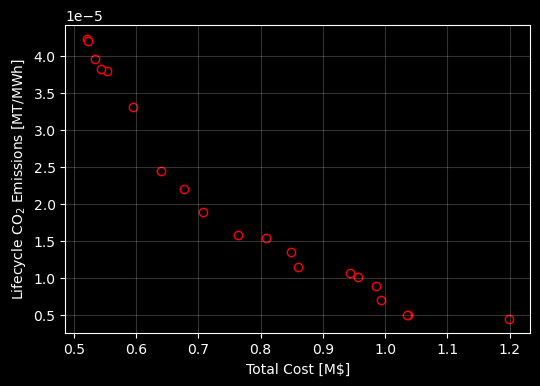

In [20]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()

### Design Results

Below is a boxplot showing the range of values for each technology in the simulation. 

**Boxplots are not the best way to visualize these results, but they are the simplest.**

Since we used boxplots, we lose information about which combination of technologies corresponds
to each solution in the objective plot, above.

The spread of these values can suggest a degree of certainty about the level of capacity needed
to meet demand while minimizing cost and emissions. We can see a huge spread in wind energy and 
very small spreads for natural gas and batteries. This indicates a no-lose scenario for pursuing
the latter two technologies, while addressing the question about the amount of wind capacity
necessary to meet demand is a lot less clear.

In [21]:
display(res.X)

array([[2.53341702, 0.04144996, 0.55710663],
       [0.81401452, 0.41946283, 0.30094145],
       [0.97601979, 0.40287869, 0.35417943],
       [1.1384407 , 0.39580232, 0.25387131],
       [1.30377163, 0.39488571, 0.25098929],
       [2.11218424, 0.09849739, 0.56117257],
       [1.21045201, 0.42561055, 0.25098929],
       [1.42508911, 0.41533998, 0.24747279],
       [1.66520048, 0.39488571, 0.25098929],
       [0.8920409 , 0.41946283, 0.30094145],
       [1.47365324, 0.50706447, 0.25557499],
       [2.03385808, 0.29352286, 0.26963251],
       [1.56593795, 0.50884959, 0.25559555],
       [1.75907345, 0.48251036, 0.34948459],
       [1.88970608, 0.50711056, 0.25422291],
       [2.10823443, 0.09849739, 0.55725319],
       [0.82023035, 0.42580387, 0.29455337],
       [1.79151691, 0.48189384, 0.34948459],
       [0.86380735, 0.41930255, 0.26382456],
       [0.88775931, 0.41930255, 0.26573897]])

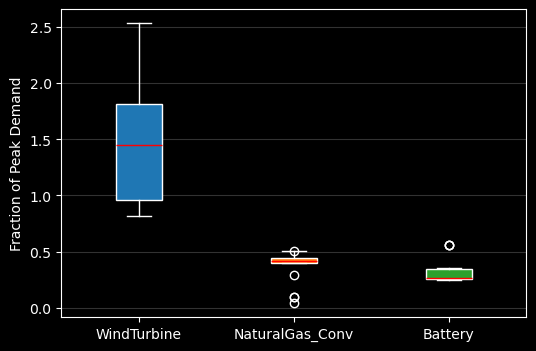

In [22]:
from osier import get_tech_names
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()

### Correlation between Wind Turbines and Natural Gas

Perhaps we can glean more information by examining the correlation between wind and natural gas.

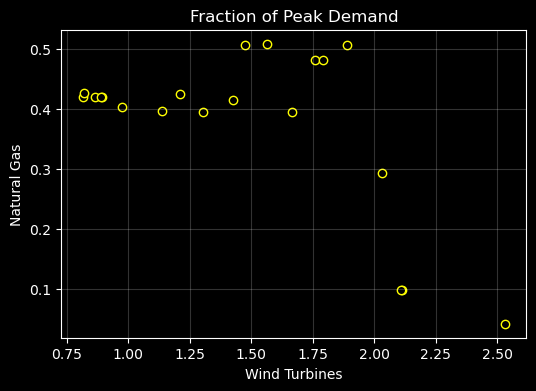

In [23]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.X[:,0], res.X[:,1], edgecolors='yellow', facecolors='k')
    ax.set_ylabel(r"Natural Gas")
    ax.set_xlabel(r"Wind Turbines")
    ax.set_title("Fraction of Peak Demand")
    ax.grid(alpha=0.2)

    plt.show()

Interestingly, the capacity for natural gas is fairly stable while the capacity for wind turbines is less than double the peak demand. But the natural gas capacity drops off quickly once the wind turbine capacity *exceeds* twice the peak demand.